<a href="https://colab.research.google.com/github/MithunCm29/MachineLearning/blob/main/Multi_Classification_using_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 ! pip install --upgrade mxnet-cu100

     |████████████████████████████████| 352.6MB 45kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
#In this program we have more than one class
#We used One vs all method . We work with class, that class is denoted by1 and the rest of classes becomes 0
#Here We used Softmax function for activation
from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

In [ ]:
data_ctx = mx.cpu()
model_ctx = mx.cpu() 

In [ ]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
mnist_train = gluon.data.vision.MNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.MNIST(train=False, transform=transform)

In [ ]:
image, label = mnist_train[0]
print(image.shape, label)

(28, 28, 1) 5.0


In [ ]:
num_inputs = 784
num_outputs = 10
num_examples = 60000

In [ ]:
im = mx.nd.tile(image, (1,1,3))
print(im.shape)

(28, 28, 3)


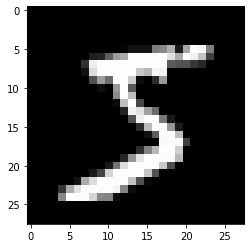

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(im.asnumpy())
plt.show()

In [ ]:
batch_size = 64
train_data = mx.gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)
W = nd.random_normal(shape=(num_inputs, num_outputs),ctx=model_ctx)
b = nd.random_normal(shape=num_outputs,ctx=model_ctx)

params = [W, b]
print(W,b)


[[-0.7637477   0.8132507   0.93579346 ... -0.28716376 -0.5686769
   0.86864537]
 [ 0.5096033  -0.44336858 -0.5278638  ... -1.3124158   0.5881744
   0.3645647 ]
 [ 0.13773616 -0.2904533   1.0496416  ... -0.7711659  -0.04313663
  -0.05840689]
 ...
 [-0.04354644  0.6713238  -0.24468939 ... -0.08005722 -0.5852295
  -0.14052571]
 [ 0.1455451  -0.12130161  0.07242323 ...  0.53267854  1.6385419
  -3.1453395 ]
 [-1.4977777  -2.3844624  -0.12073093 ... -1.2506124   1.9484453
  -0.8560787 ]]
<NDArray 784x10 @cpu(0)> 
[ 0.07038765 -1.5526806  -1.009325   -0.47292903 -0.3531269   0.80765224
 -0.9618061  -0.628697   -0.72768885 -0.9264513 ]
<NDArray 10 @cpu(0)>


In [ ]:
for param in params:
    param.attach_grad()
print(param)


[ 0.07038765 -1.5526806  -1.009325   -0.47292903 -0.3531269   0.80765224
 -0.9618061  -0.628697   -0.72768885 -0.9264513 ]
<NDArray 10 @cpu(0)>


In [ ]:
def softmax(y_linear):
    exp = nd.exp(y_linear-nd.max(y_linear, axis=1).reshape((-1,1)))
    norms = nd.sum(exp, axis=1).reshape((-1,1))
    return exp / norms
sample_y_linear = nd.random_normal(shape=(2,10))
sample_yhat = softmax(sample_y_linear)
print(sample_yhat)
print(nd.sum(sample_yhat, axis=1))


[[0.37602234 0.01054419 0.03734268 0.0339198  0.04515602 0.07530785
  0.1562652  0.08775889 0.1267912  0.05089178]
 [0.05164693 0.02814769 0.04309661 0.05293715 0.05930832 0.03224321
  0.01246455 0.05107995 0.10779051 0.561285  ]]
<NDArray 2x10 @cpu(0)>

[0.99999994 0.99999994]
<NDArray 2 @cpu(0)>


In [ ]:
def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = softmax(y_linear)
    return yhat
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat+1e-6))
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
    return (numerator / denominator).asscalar()
evaluate_accuracy(test_data, net)

0.0758

In [ ]:
#Trainig
epochs = 5
learning_rate = .005

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += nd.sum(loss).asscalar()


    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))


Epoch 0. Loss: 1.2142378908316294, Train_acc 0.8609167, Test_acc 0.8671
Epoch 1. Loss: 0.585679920955499, Train_acc 0.8811833, Test_acc 0.8854
Epoch 2. Loss: 0.4982278858661652, Train_acc 0.8911833, Test_acc 0.895
Epoch 3. Loss: 0.4517723655362924, Train_acc 0.89765, Test_acc 0.9006
Epoch 4. Loss: 0.4218993454655012, Train_acc 0.9004167, Test_acc 0.9033


(10, 28, 28, 1)


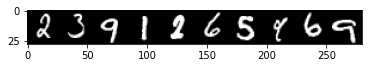

model predictions are: 
[2. 3. 9. 1. 8. 6. 5. 8. 6. 9.]
<NDArray 10 @cpu(0)>


In [ ]:
# Define the function to do prediction
def model_predict(net,data):
    output = net(data)
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mnist_test, 10, shuffle=True)
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break